In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *

2024-07-18 09:37:18.458469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import glob
import os

In [3]:
def read_csv_files_into_dataframe(folder_path):
    # Use glob to find all CSV files in the specified folder
    csv_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    # Read each CSV file into a list of DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]
    
    # Concatenate all DataFrames into a single DataFrame
    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return combined_dataframe

In [4]:
folder_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/results_BGMMFit/'

combined_df = read_csv_files_into_dataframe(folder_path)

In [6]:
combined_df.columns

Index(['num_monomers', 'mean_bond_length', 'std_bond_length', 'num_templates',
       'weights_dist', 'noise_std', 'num_observations', 'mean_mse', 'cov_mse',
       'cov_corr', 'weight_corr', 'weight_kl', 'log_likelihood', 'ami_score'],
      dtype='object')

In [5]:
param_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/parameter_mapping.csv'

param_df = pd.read_csv(param_path)

In [6]:
sns.set_theme(style="darkgrid")

In [6]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240627/'

In [7]:
num_temp = [2, 5, 10, 50, 100]
mse_loss_array = []
for iter in tqdm(range(100)):
    mse_loss_list = []
    for i in num_temp:
        rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
        rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
        assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
        mse_loss = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
        mse_loss_list.append(mse_loss)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 100)
kl_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
    kl_loss_array.append(kl_loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
mse_loss_mean = np.mean(mse_loss_array, axis=0)

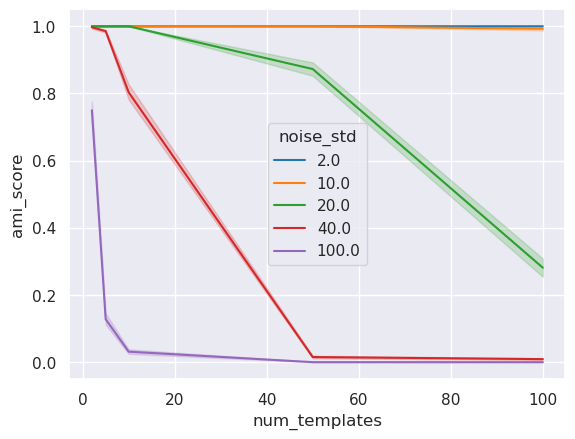

In [29]:
conditions = (combined_df['weights_dist'] == 1000) & (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
sns.lineplot(conditional_df, x='num_templates', y='ami_score', hue='noise_std', palette='tab10')
# plt.savefig(save_folder + 'ami_score_vs_num_templates_noise.png', dpi=300)

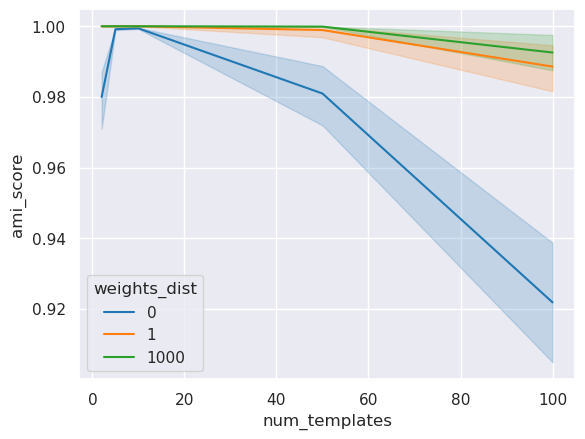

In [30]:
conditions = (combined_df['noise_std'] == 10.) & (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
sns.lineplot(conditional_df, x='num_templates', y='ami_score', hue='weights_dist', palette='tab10')
plt.savefig(save_folder + 'ami_score_vs_num_templates_weights.png', dpi=300)

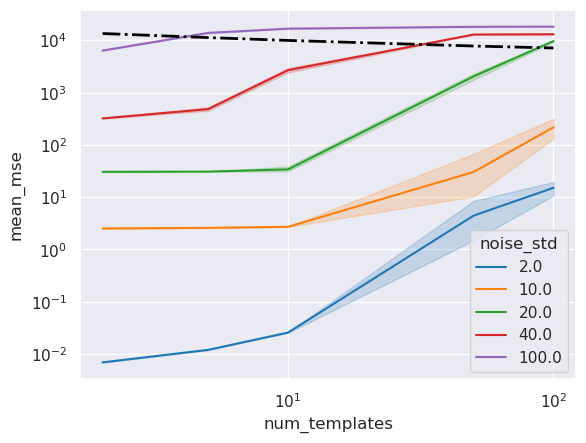

In [26]:
conditions = (combined_df['weights_dist'] == 1)& (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
sns.lineplot(conditional_df, x='num_templates', y='mean_mse', hue='noise_std', palette='tab10')
plt.plot(num_temp, mse_loss_mean, label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')

plt.xscale('log')
plt.yscale('log')
# plt.savefig(save_folder + 'mean_mse_vs_num_templates_noise.png', dpi=300)

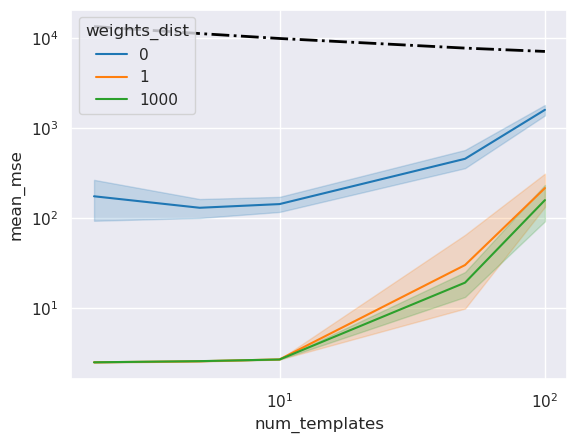

In [27]:
conditions = (combined_df['noise_std'] == 10.) & (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
sns.lineplot(conditional_df, x='num_templates', y='mean_mse', hue='weights_dist', palette='tab10')
plt.plot(num_temp, mse_loss_mean, label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')
plt.xscale('log')
plt.yscale('log')
# plt.savefig(save_folder + 'mean_mse_vs_num_templates_weights.png', dpi=300)

In [12]:
kl_loss_mean = np.mean(kl_loss_array, axis=0)

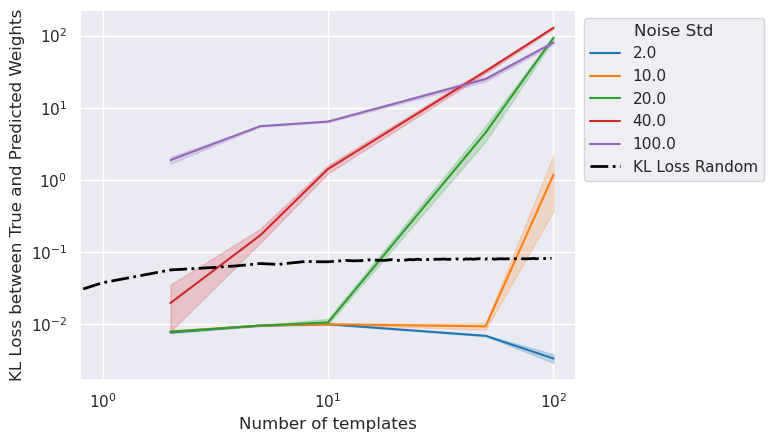

In [31]:
conditions = (combined_df['weights_dist'] == 1000) & (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='weight_kl', hue='noise_std', palette='tab10')

plt.plot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

plt.yscale('log')
plt.xscale('log')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.legend(title='Noise Std', loc='upper left', bbox_to_anchor=(1, 1))
# plt.savefig(save_folder + 'kl_weights_num_templates_noise.png', dpi=300)

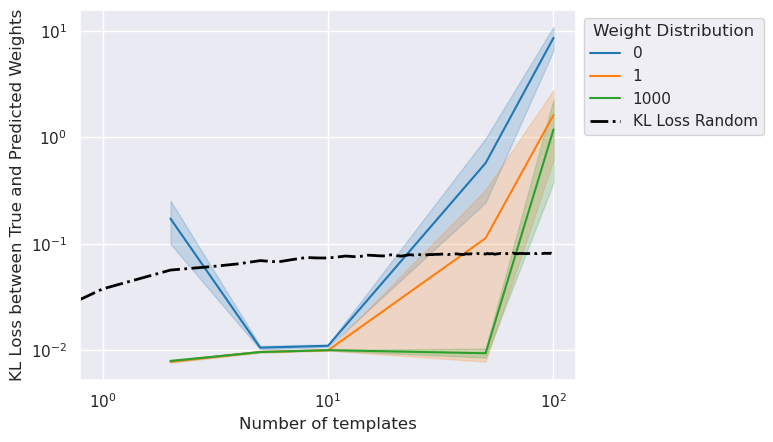

In [32]:
conditions = (combined_df['noise_std'] == 10.) & (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='weight_kl', hue='weights_dist', palette='tab10')

plt.plot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

plt.yscale('log')
plt.xscale('log')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.legend(title='Weight Distribution', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'kl_weights_num_templates_weight_dist.png', dpi=300)

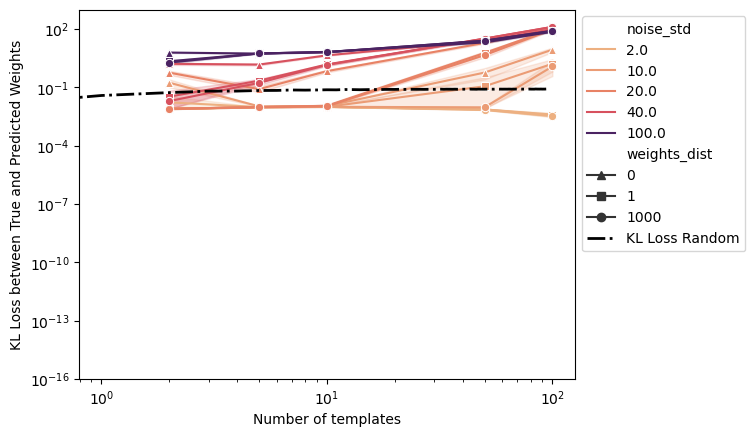

In [27]:
conditions = (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='weight_kl', hue='noise_std', style='weights_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])

sns.lineplot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

plt.yscale('log')
plt.xscale('log')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.ylim([1e-16, 1e3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'kl_weights_num_templates_combined.png', dpi=300, bbox_inches='tight')

In [14]:
mse_loss_mean

array([12821.60019941, 11017.56603854,  9875.06450953,  7669.2788564 ,
        7132.1353963 ])

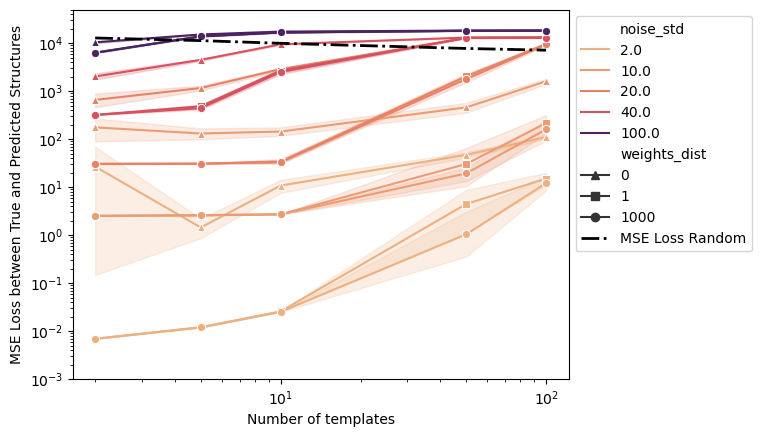

In [26]:
num_temp = [2, 5, 10, 50, 100]
conditions = (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='mean_mse', hue='noise_std', style='weights_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])
plt.plot(num_temp, mse_loss_mean, label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')

plt.xscale('log')
plt.yscale('log')

p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.ylim([1e-3, 5e4])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'mean_mse_num_templates_combined.png', dpi=300, bbox_inches='tight')

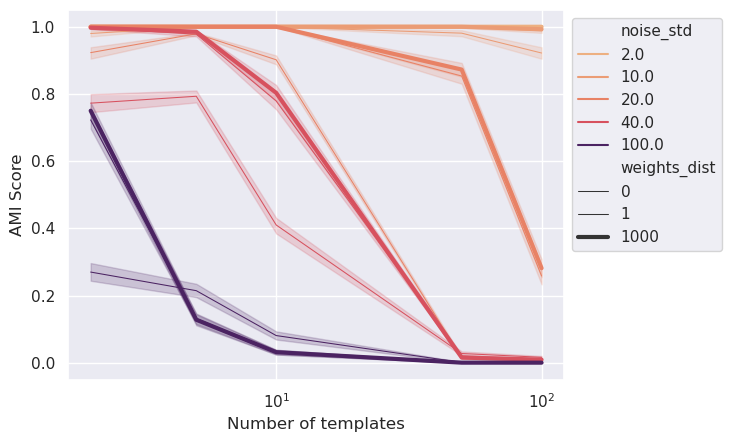

In [16]:
conditions = (combined_df['num_templates'] < 250)
conditional_df = combined_df[conditions]
p = sns.lineplot(conditional_df, x='num_templates', y='ami_score', hue='noise_std', size='weights_dist', palette="flare")
plt.xscale('log')


p.set_ylabel('AMI Score')
p.set_xlabel('Number of templates')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(save_folder + 'ami_num_templates_combined.png', dpi=300, bbox_inches='tight')

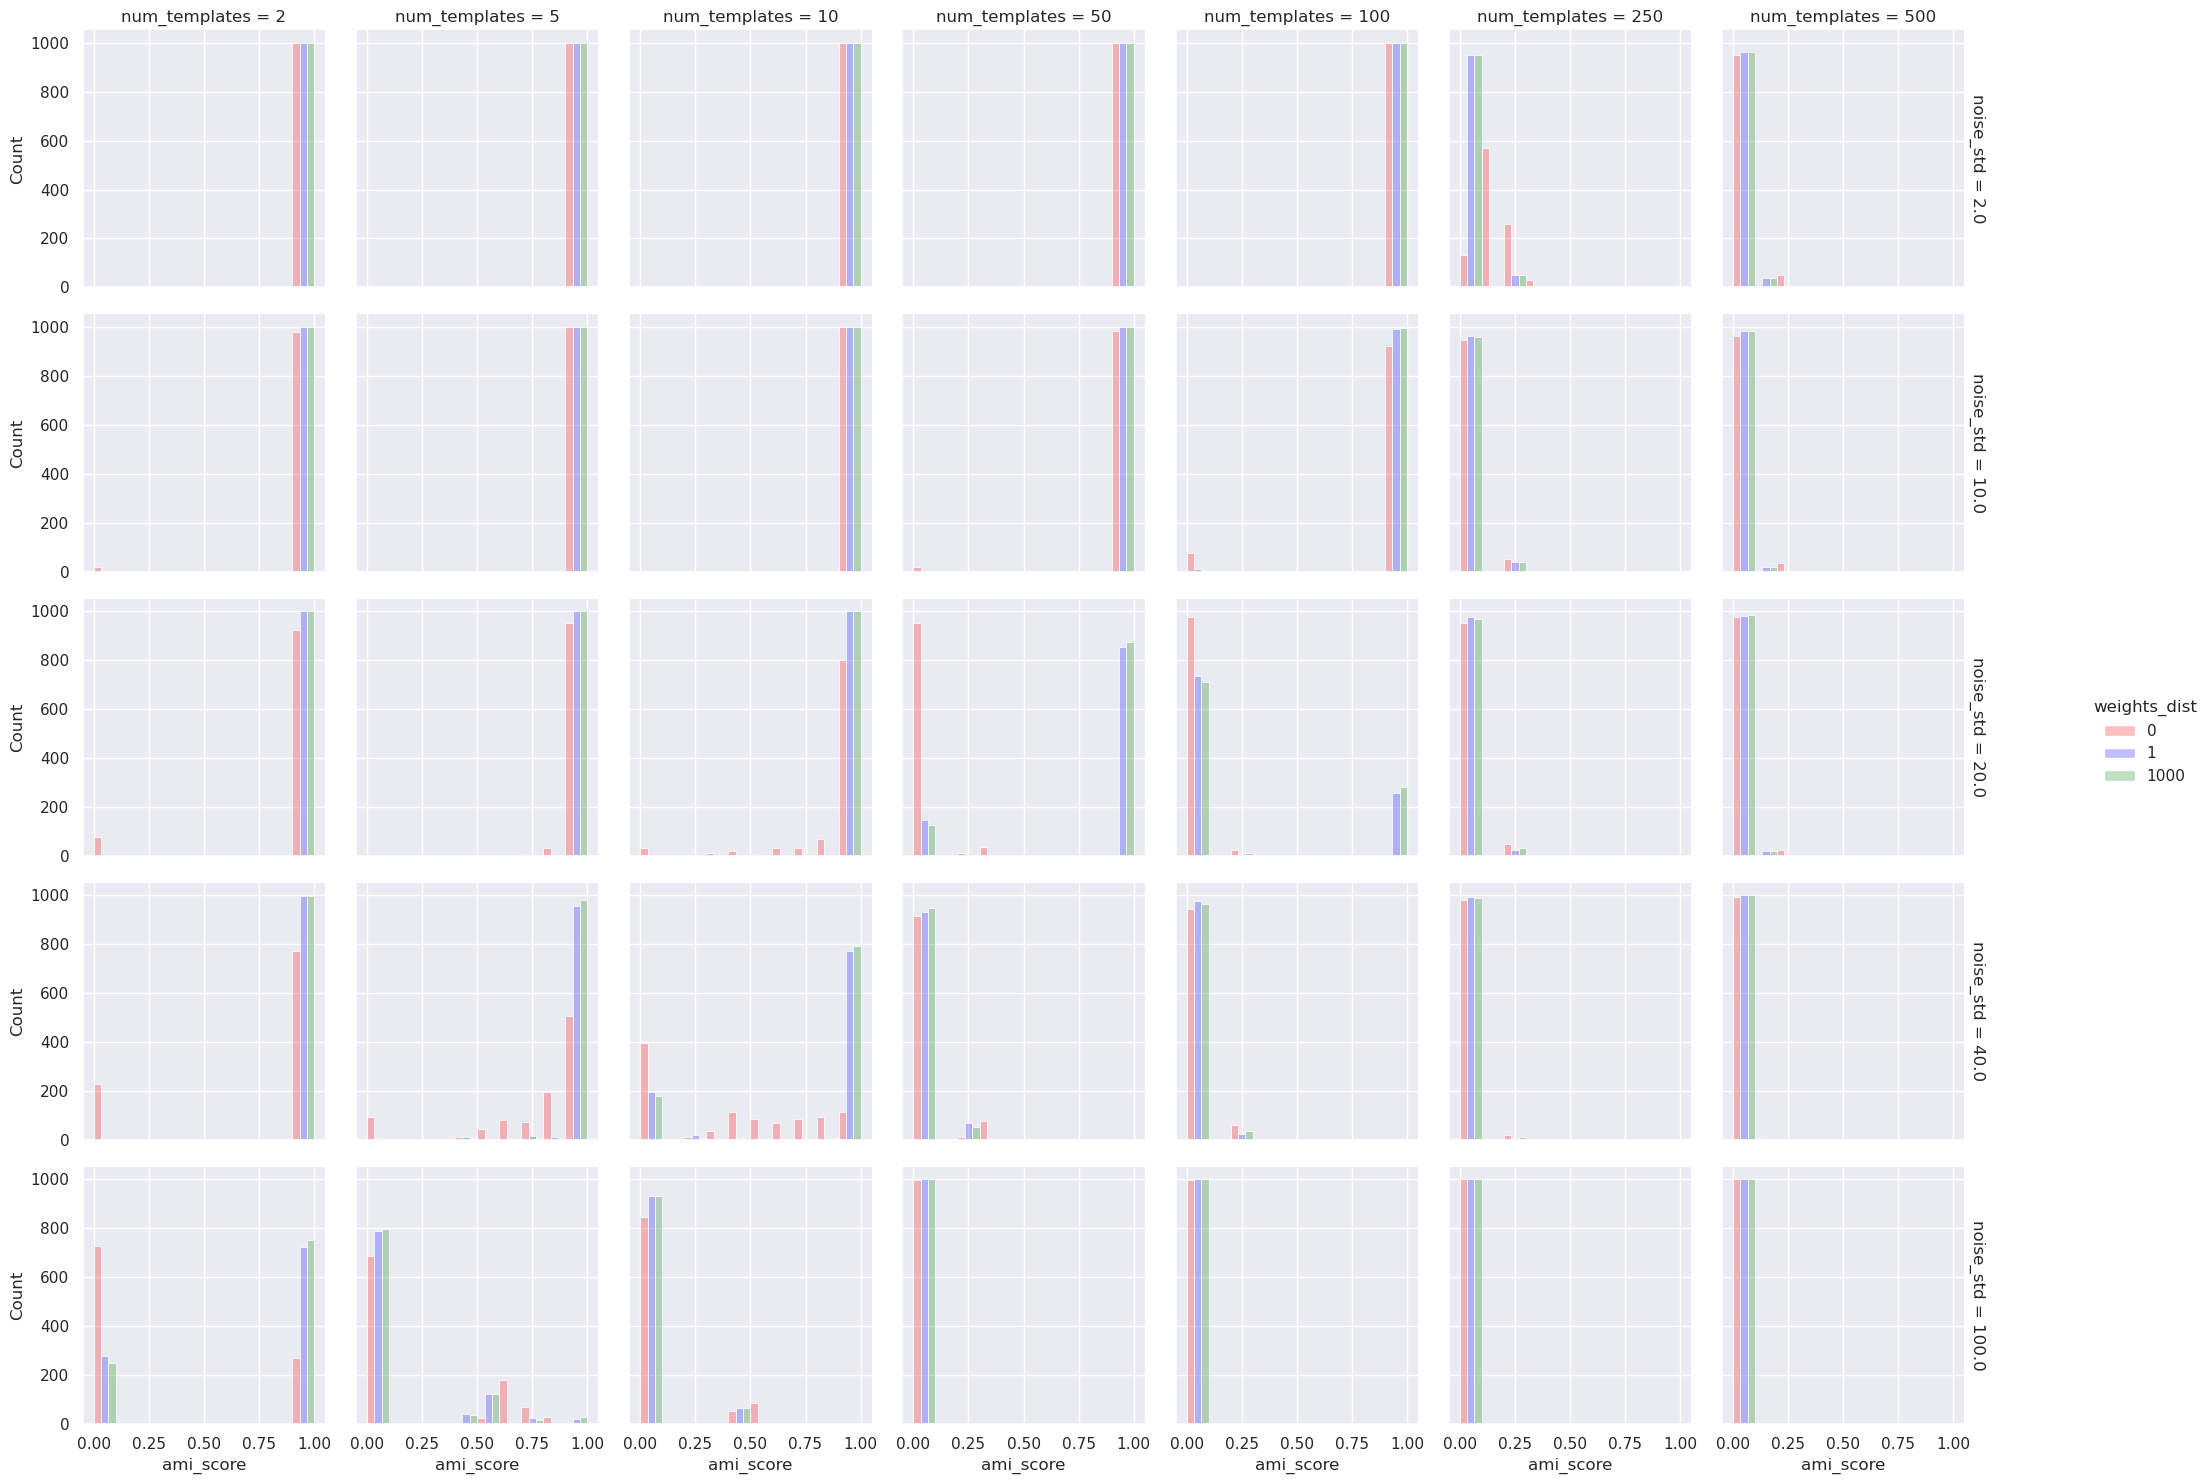

In [31]:
from matplotlib.colors import ListedColormap

conditions = (combined_df['weights_dist'] == 0) & (combined_df['noise_std'] == 2.)
conditional_df = combined_df[conditions]

colors = ['red', 'green', 'blue']
unique_weights = combined_df['weights_dist'].unique()
palette = dict(zip(unique_weights, colors))

sns.displot(
    combined_df, x="ami_score", col="num_templates", row="noise_std",
    height=3, facet_kws=dict(margin_titles=True), stat='count', hue="weights_dist", multiple='dodge', bins=10, kind='hist', palette=palette, alpha=0.25)
plt.savefig(save_folder + 'ami_score_distribution_weights.png', dpi=300)

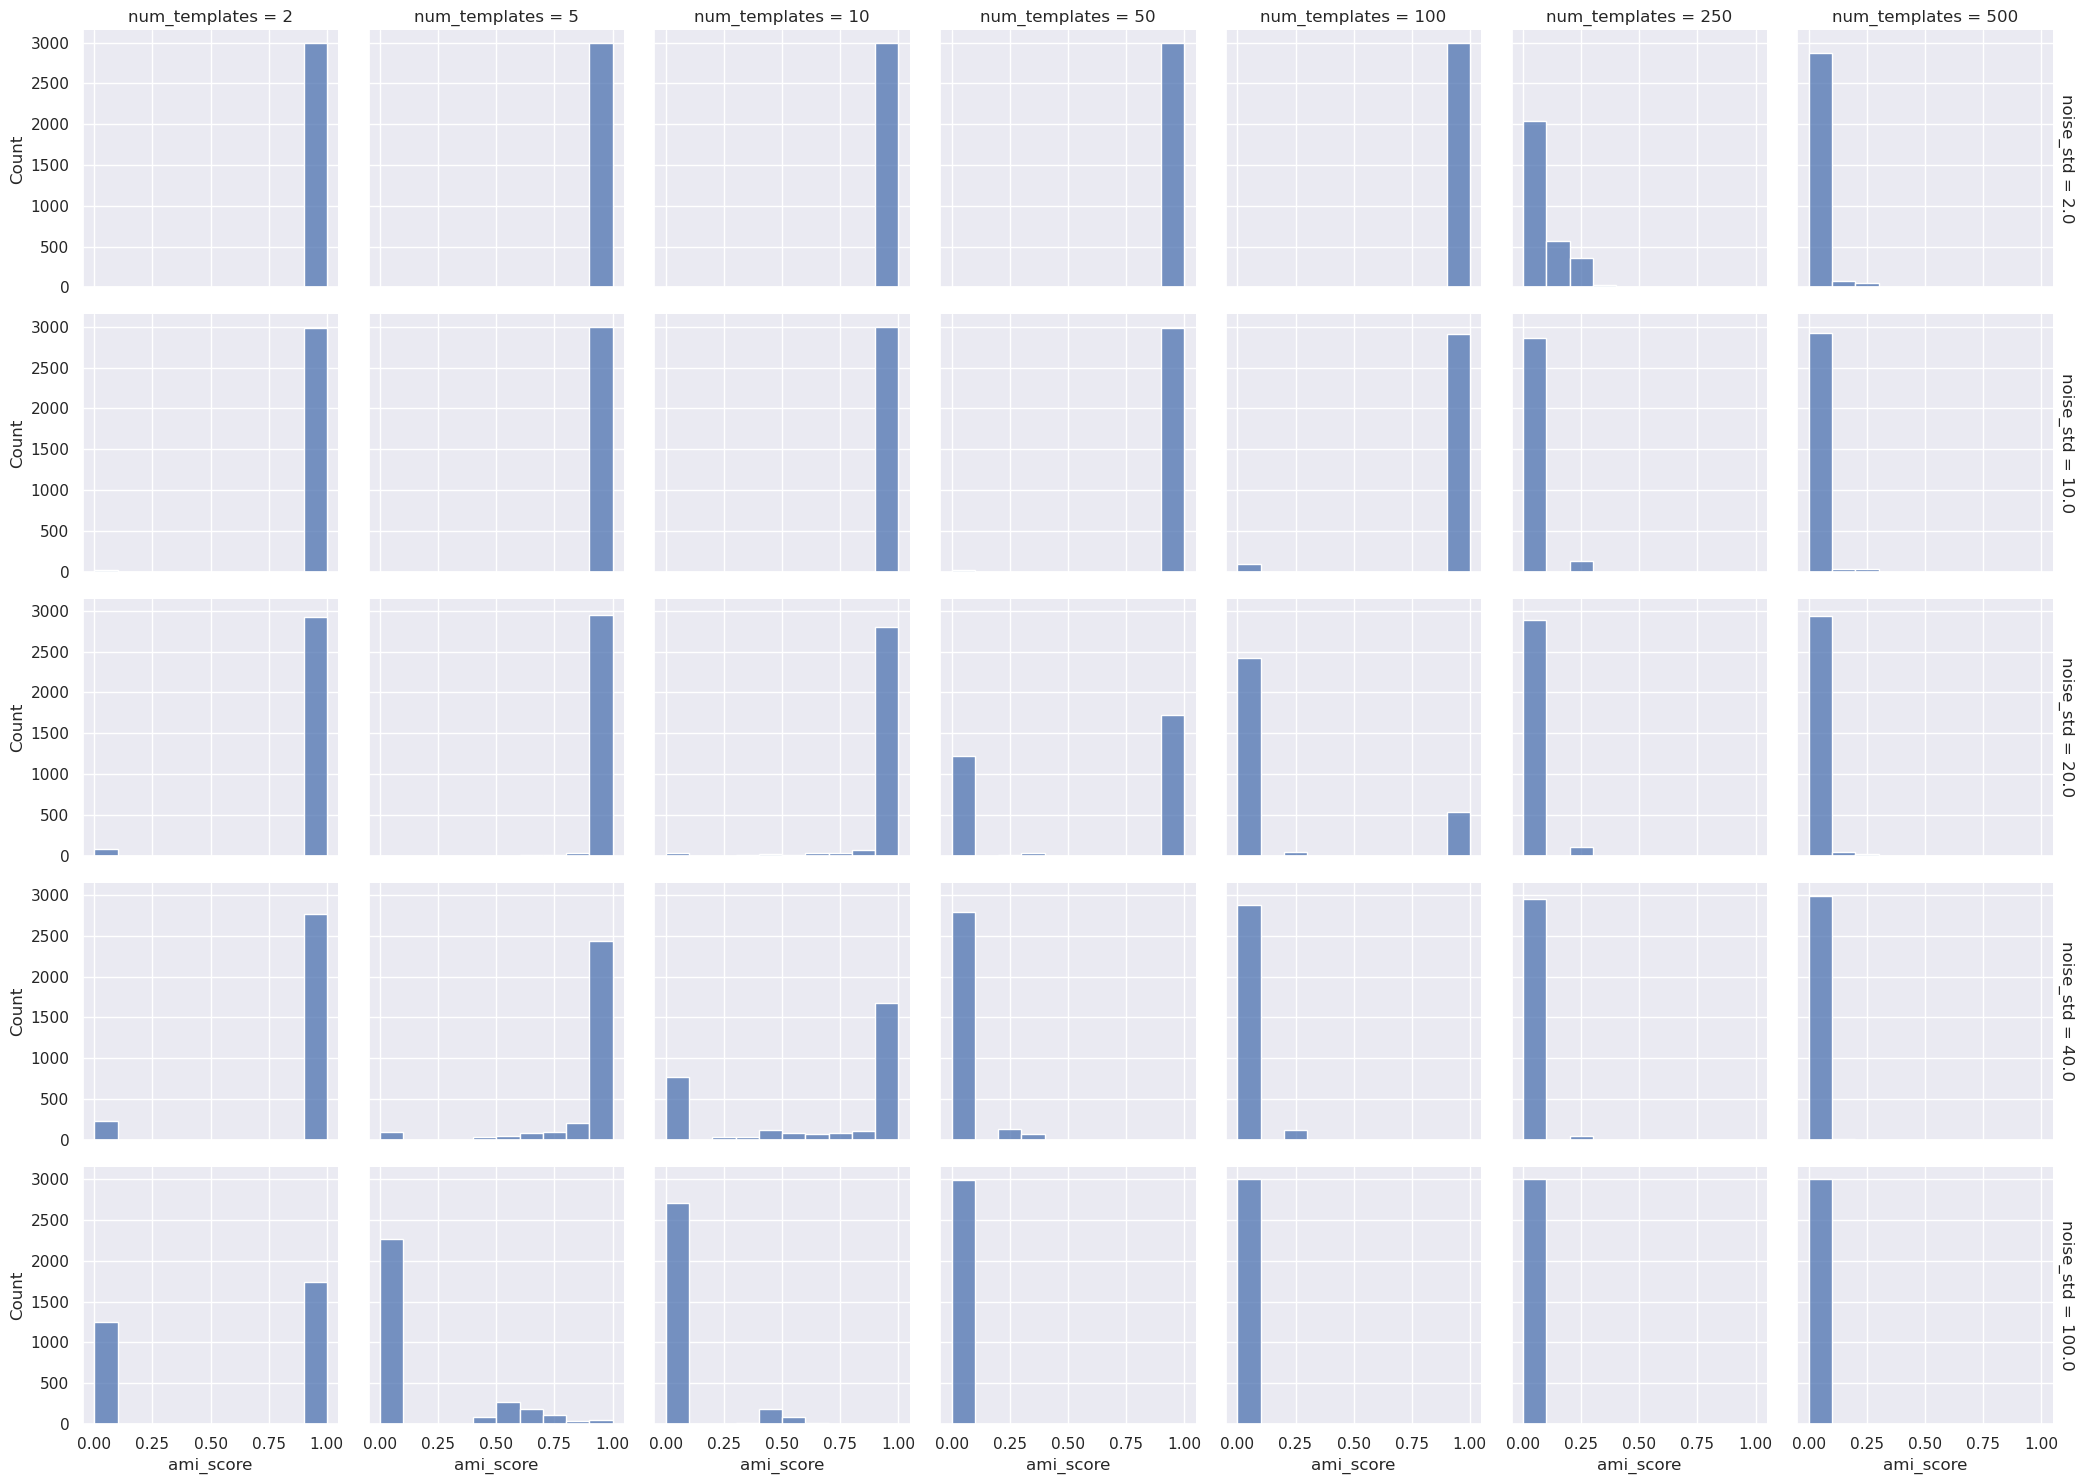

In [32]:
# Draw a categorical scatterplot to show each observation
sns.displot(
    combined_df, x="ami_score", col="num_templates", row="noise_std",
    height=3, facet_kws=dict(margin_titles=True), stat='count', bins=10
)
plt.savefig(save_folder + 'ami_score_distribution.png', dpi=300)

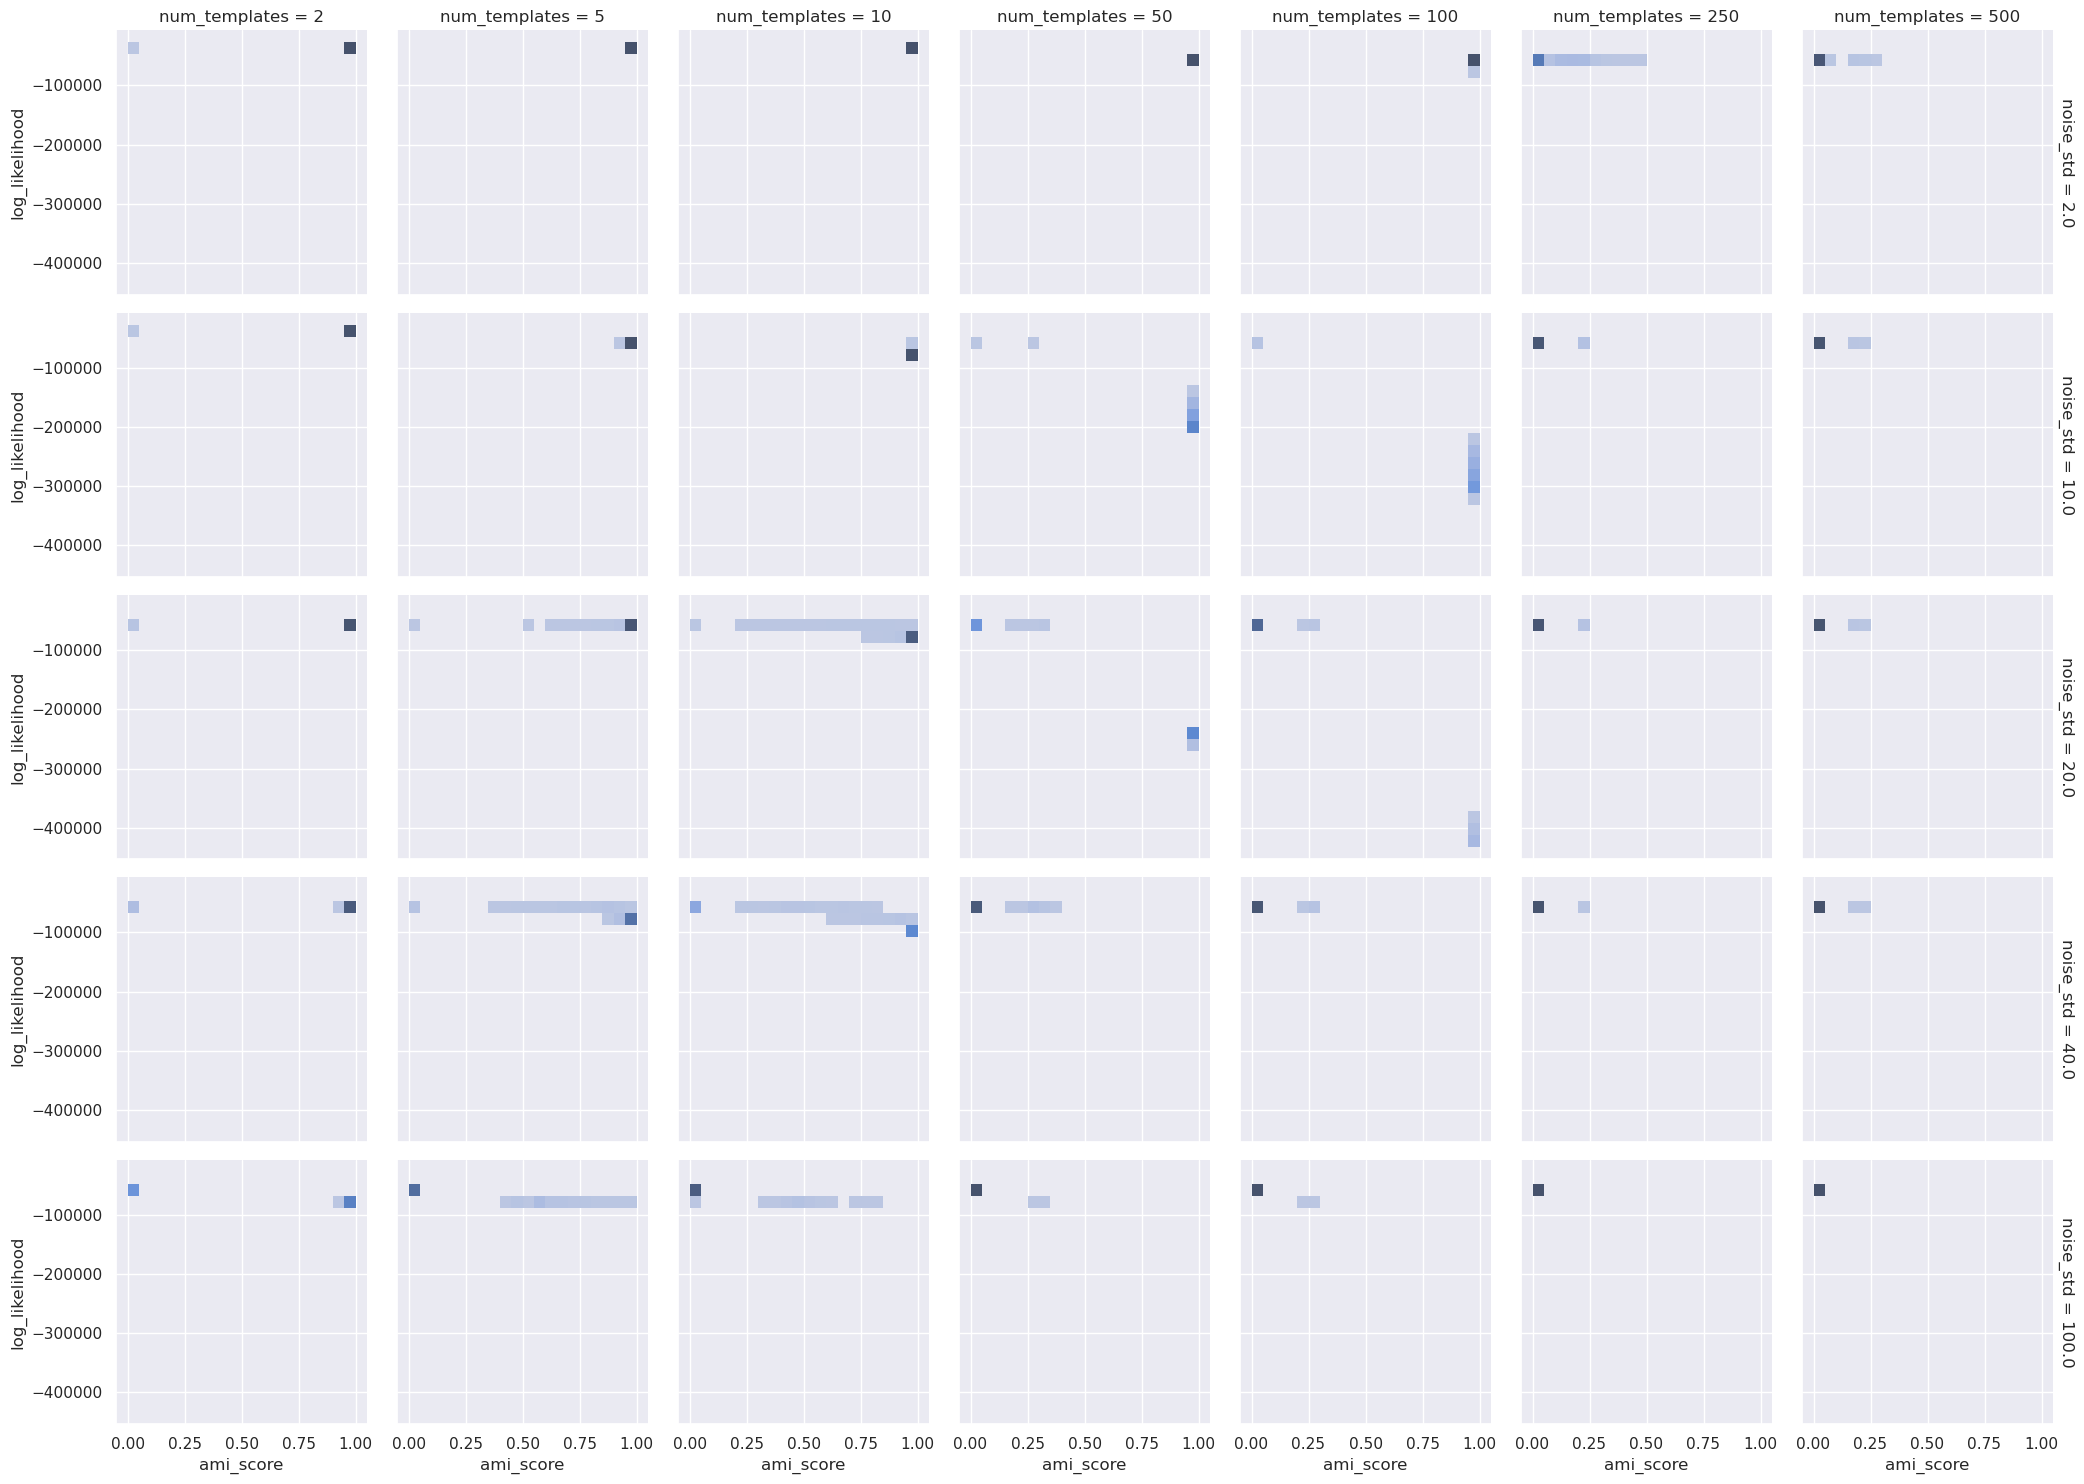

In [51]:
# Draw a categorical scatterplot to show each observation
sns.displot(
    combined_df, x="ami_score", y='log_likelihood', col="num_templates", row="noise_std",
    height=3, facet_kws=dict(margin_titles=True), bins=20
)
plt.savefig(save_folder + 'ami_score_ll.png', dpi=300)

In [43]:
# Discretize 'ami_score'
combined_df['ami_score_bins'] = pd.cut(combined_df['ami_score'], bins=10, labels=False)


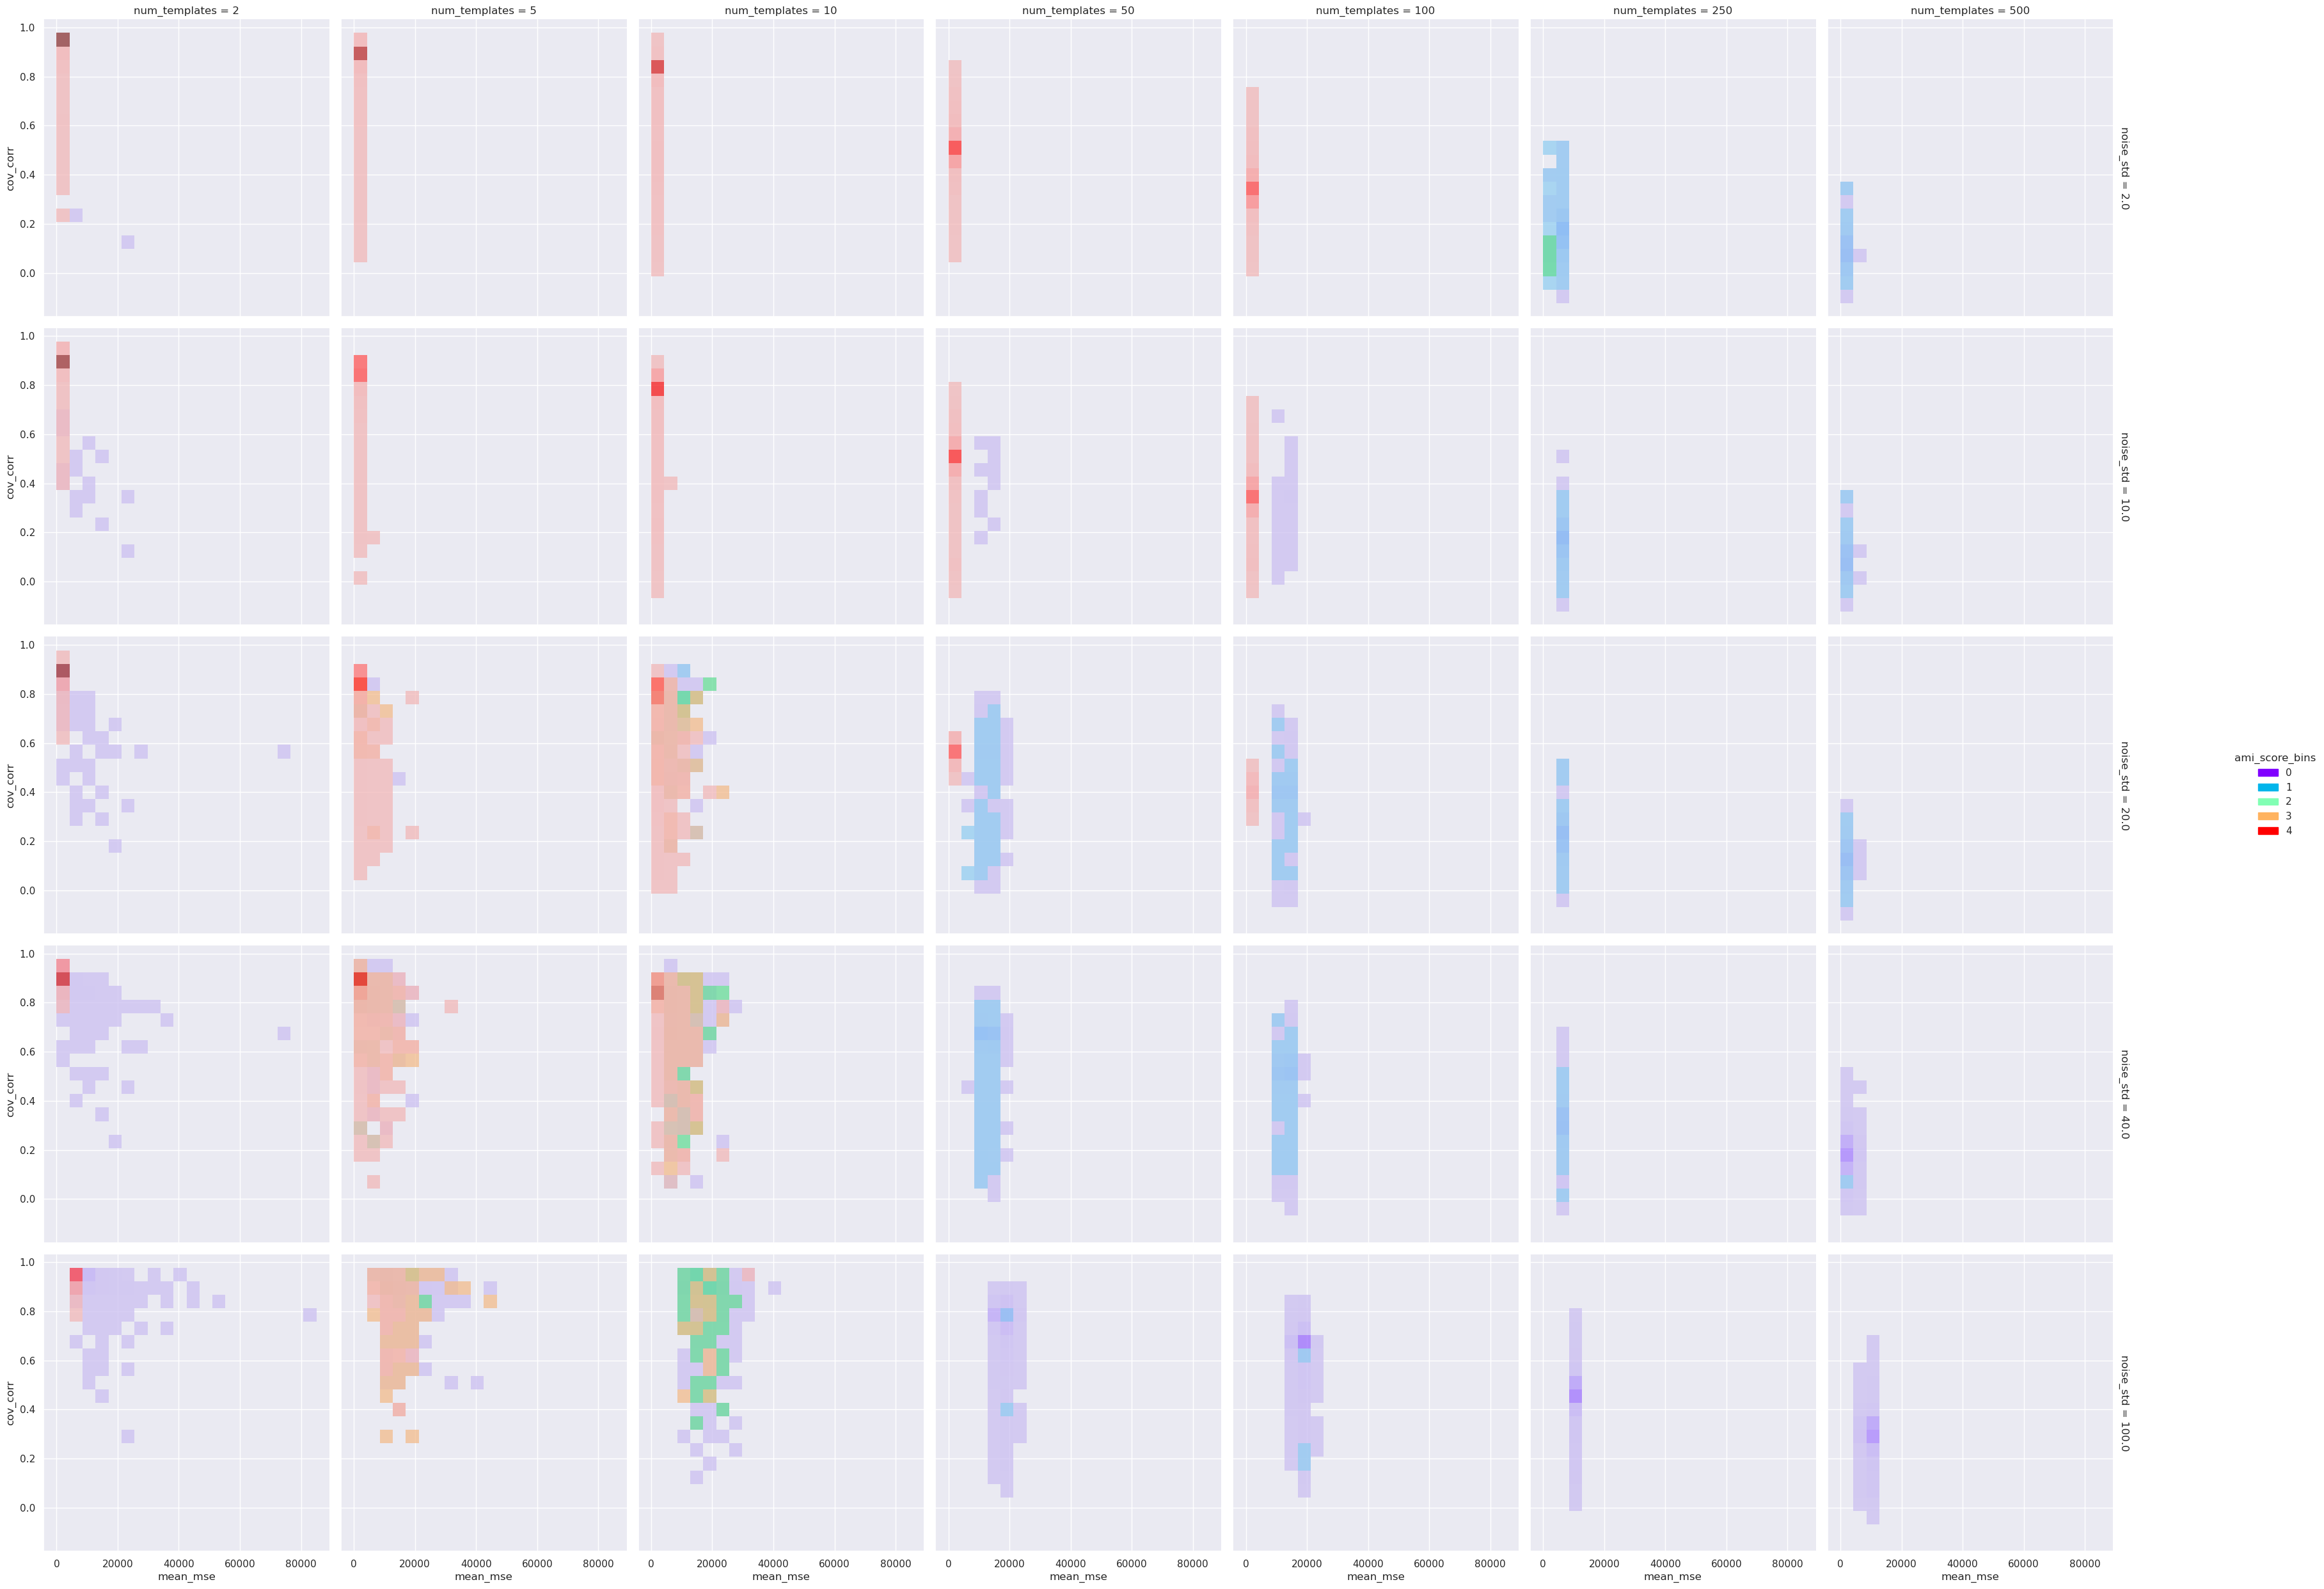

In [54]:
sns.displot(data=combined_df, 
                x="mean_mse", y='cov_corr', col="num_templates", row="noise_std",    
                facet_kws=dict(margin_titles=True), hue='ami_score_bins', alpha=0.75, palette='rainbow', bins=20)

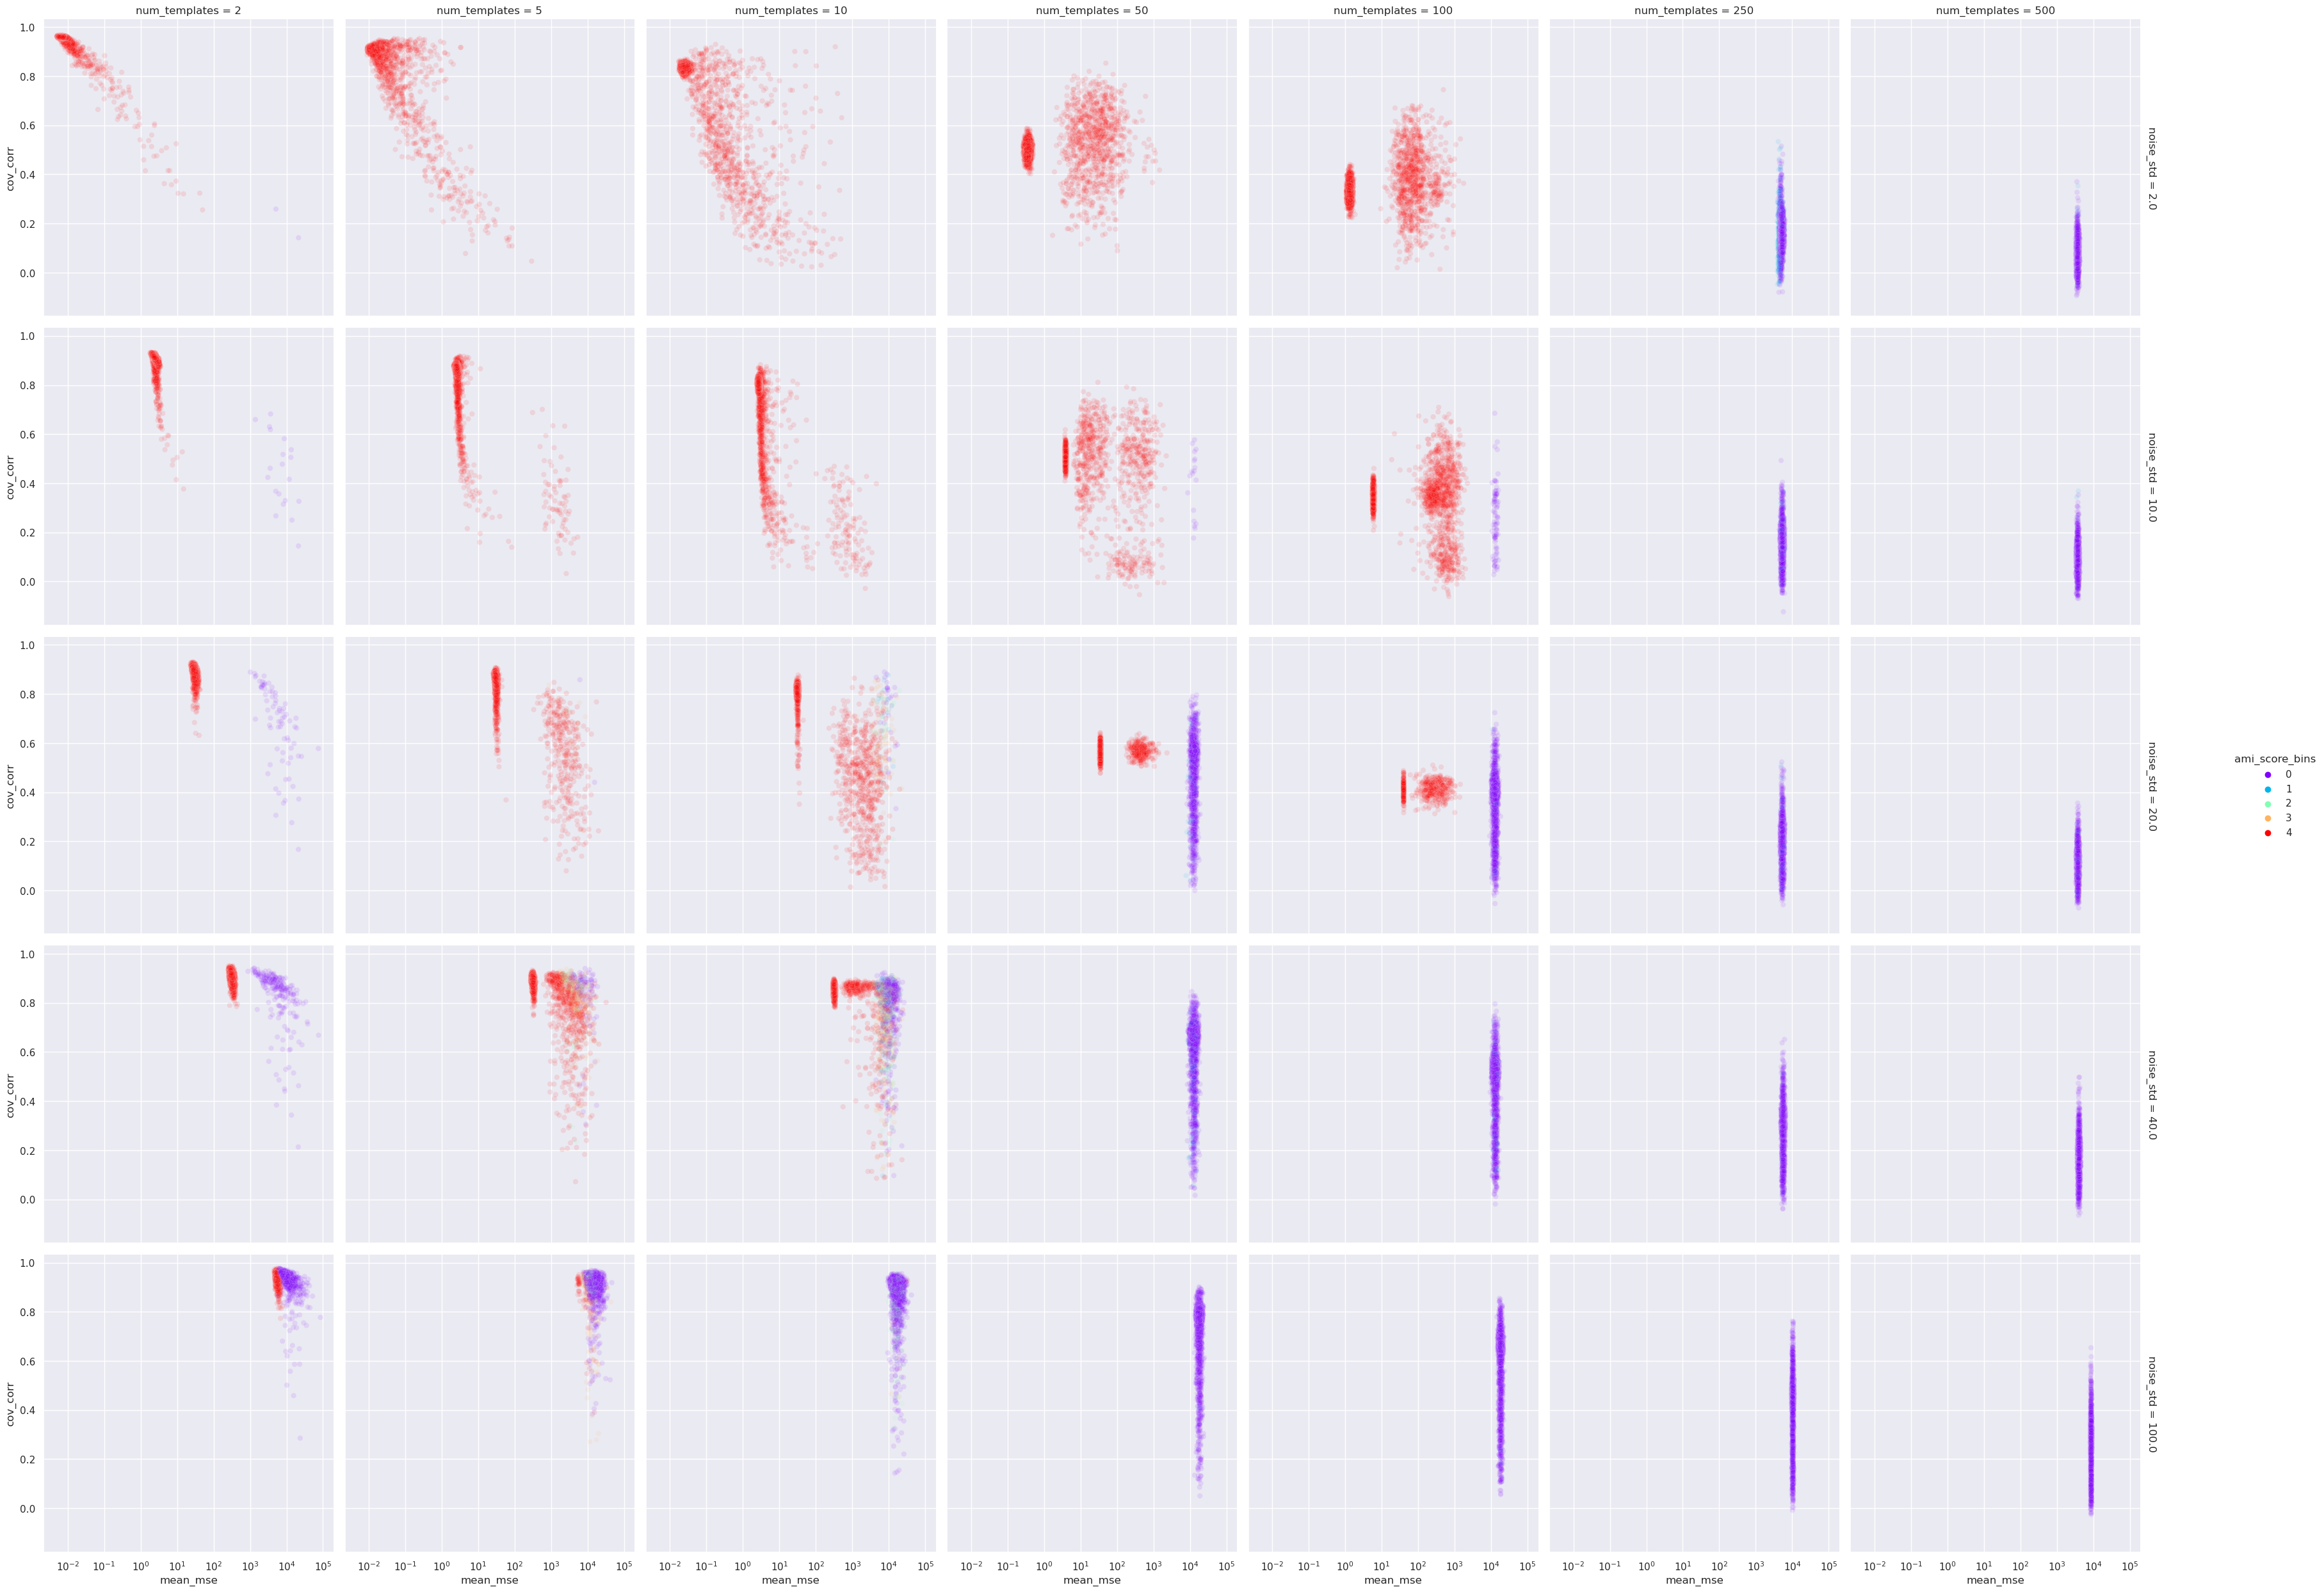

In [52]:
g = sns.relplot(data=combined_df, 
                x="mean_mse", y='cov_corr', col="num_templates", row="noise_std",    
                facet_kws=dict(margin_titles=True), hue='ami_score_bins', alpha=0.1, palette='rainbow')


# Set log scale for x-axis and/or y-axis
g.set(xscale="log")

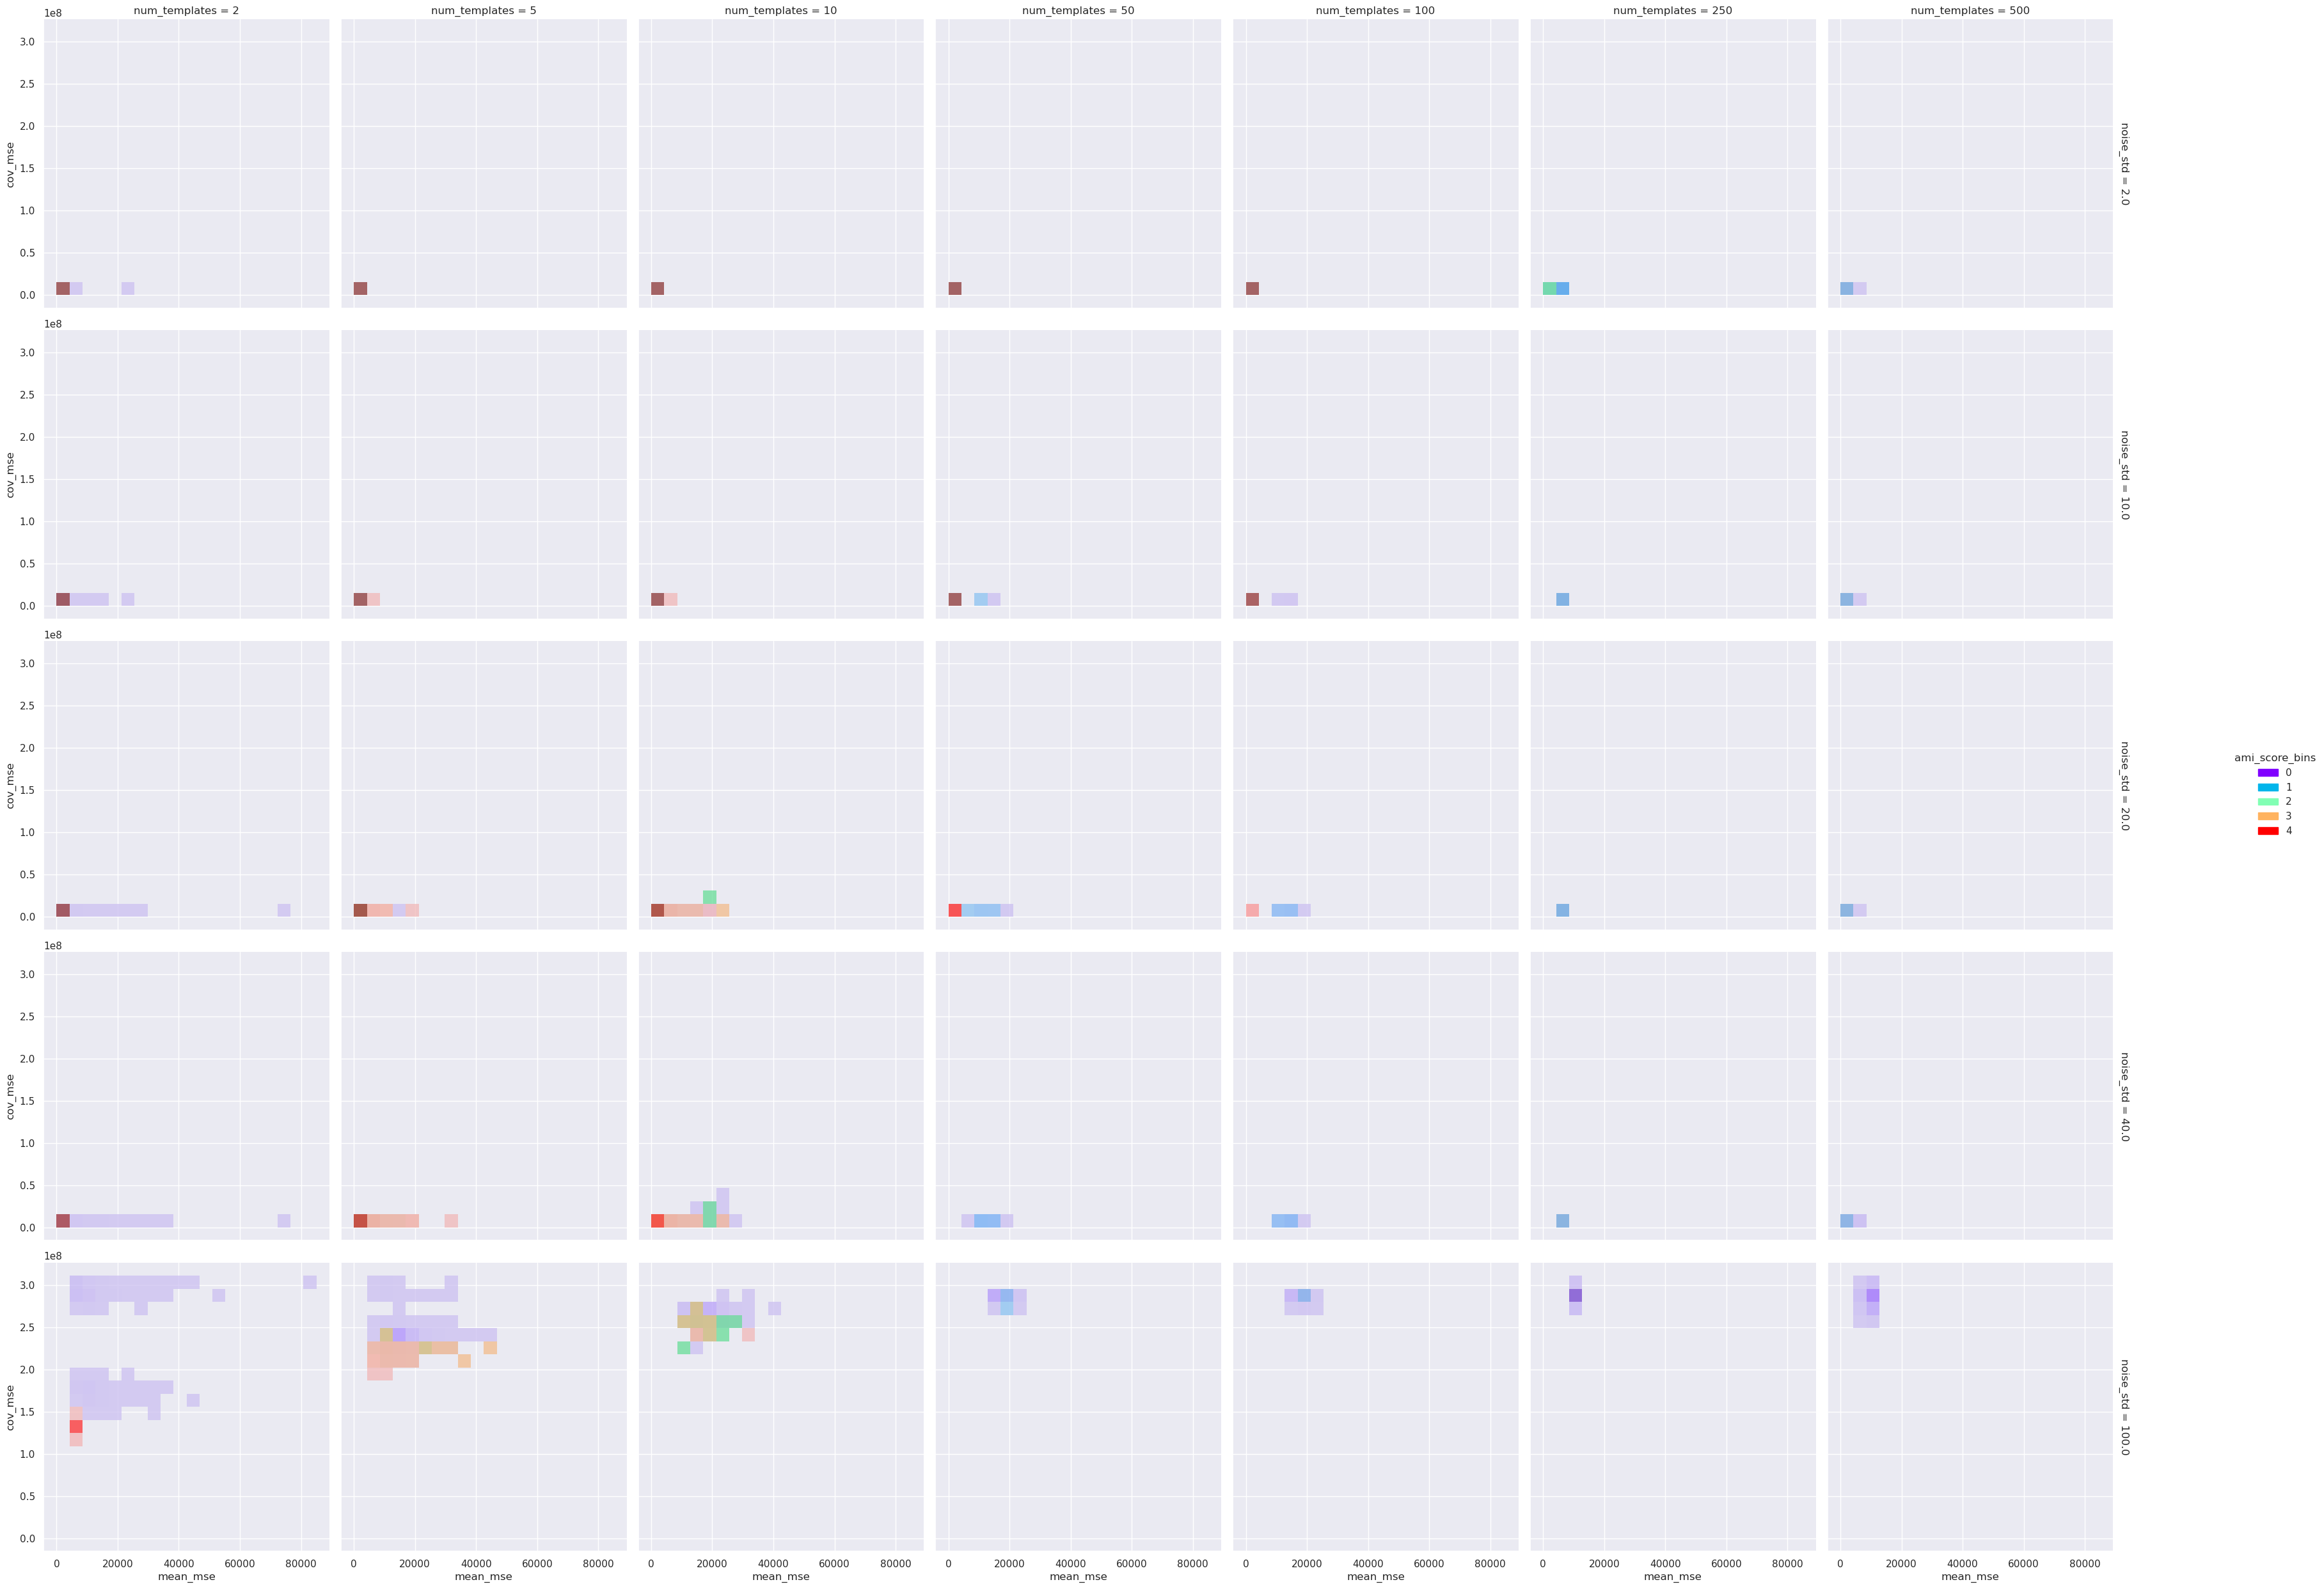

In [58]:
g = sns.displot(data=combined_df, 
                x="mean_mse", y='cov_mse', col="num_templates", row="noise_std",    
                facet_kws=dict(margin_titles=True), hue='ami_score_bins', alpha=0.75, palette='rainbow', bins=20)


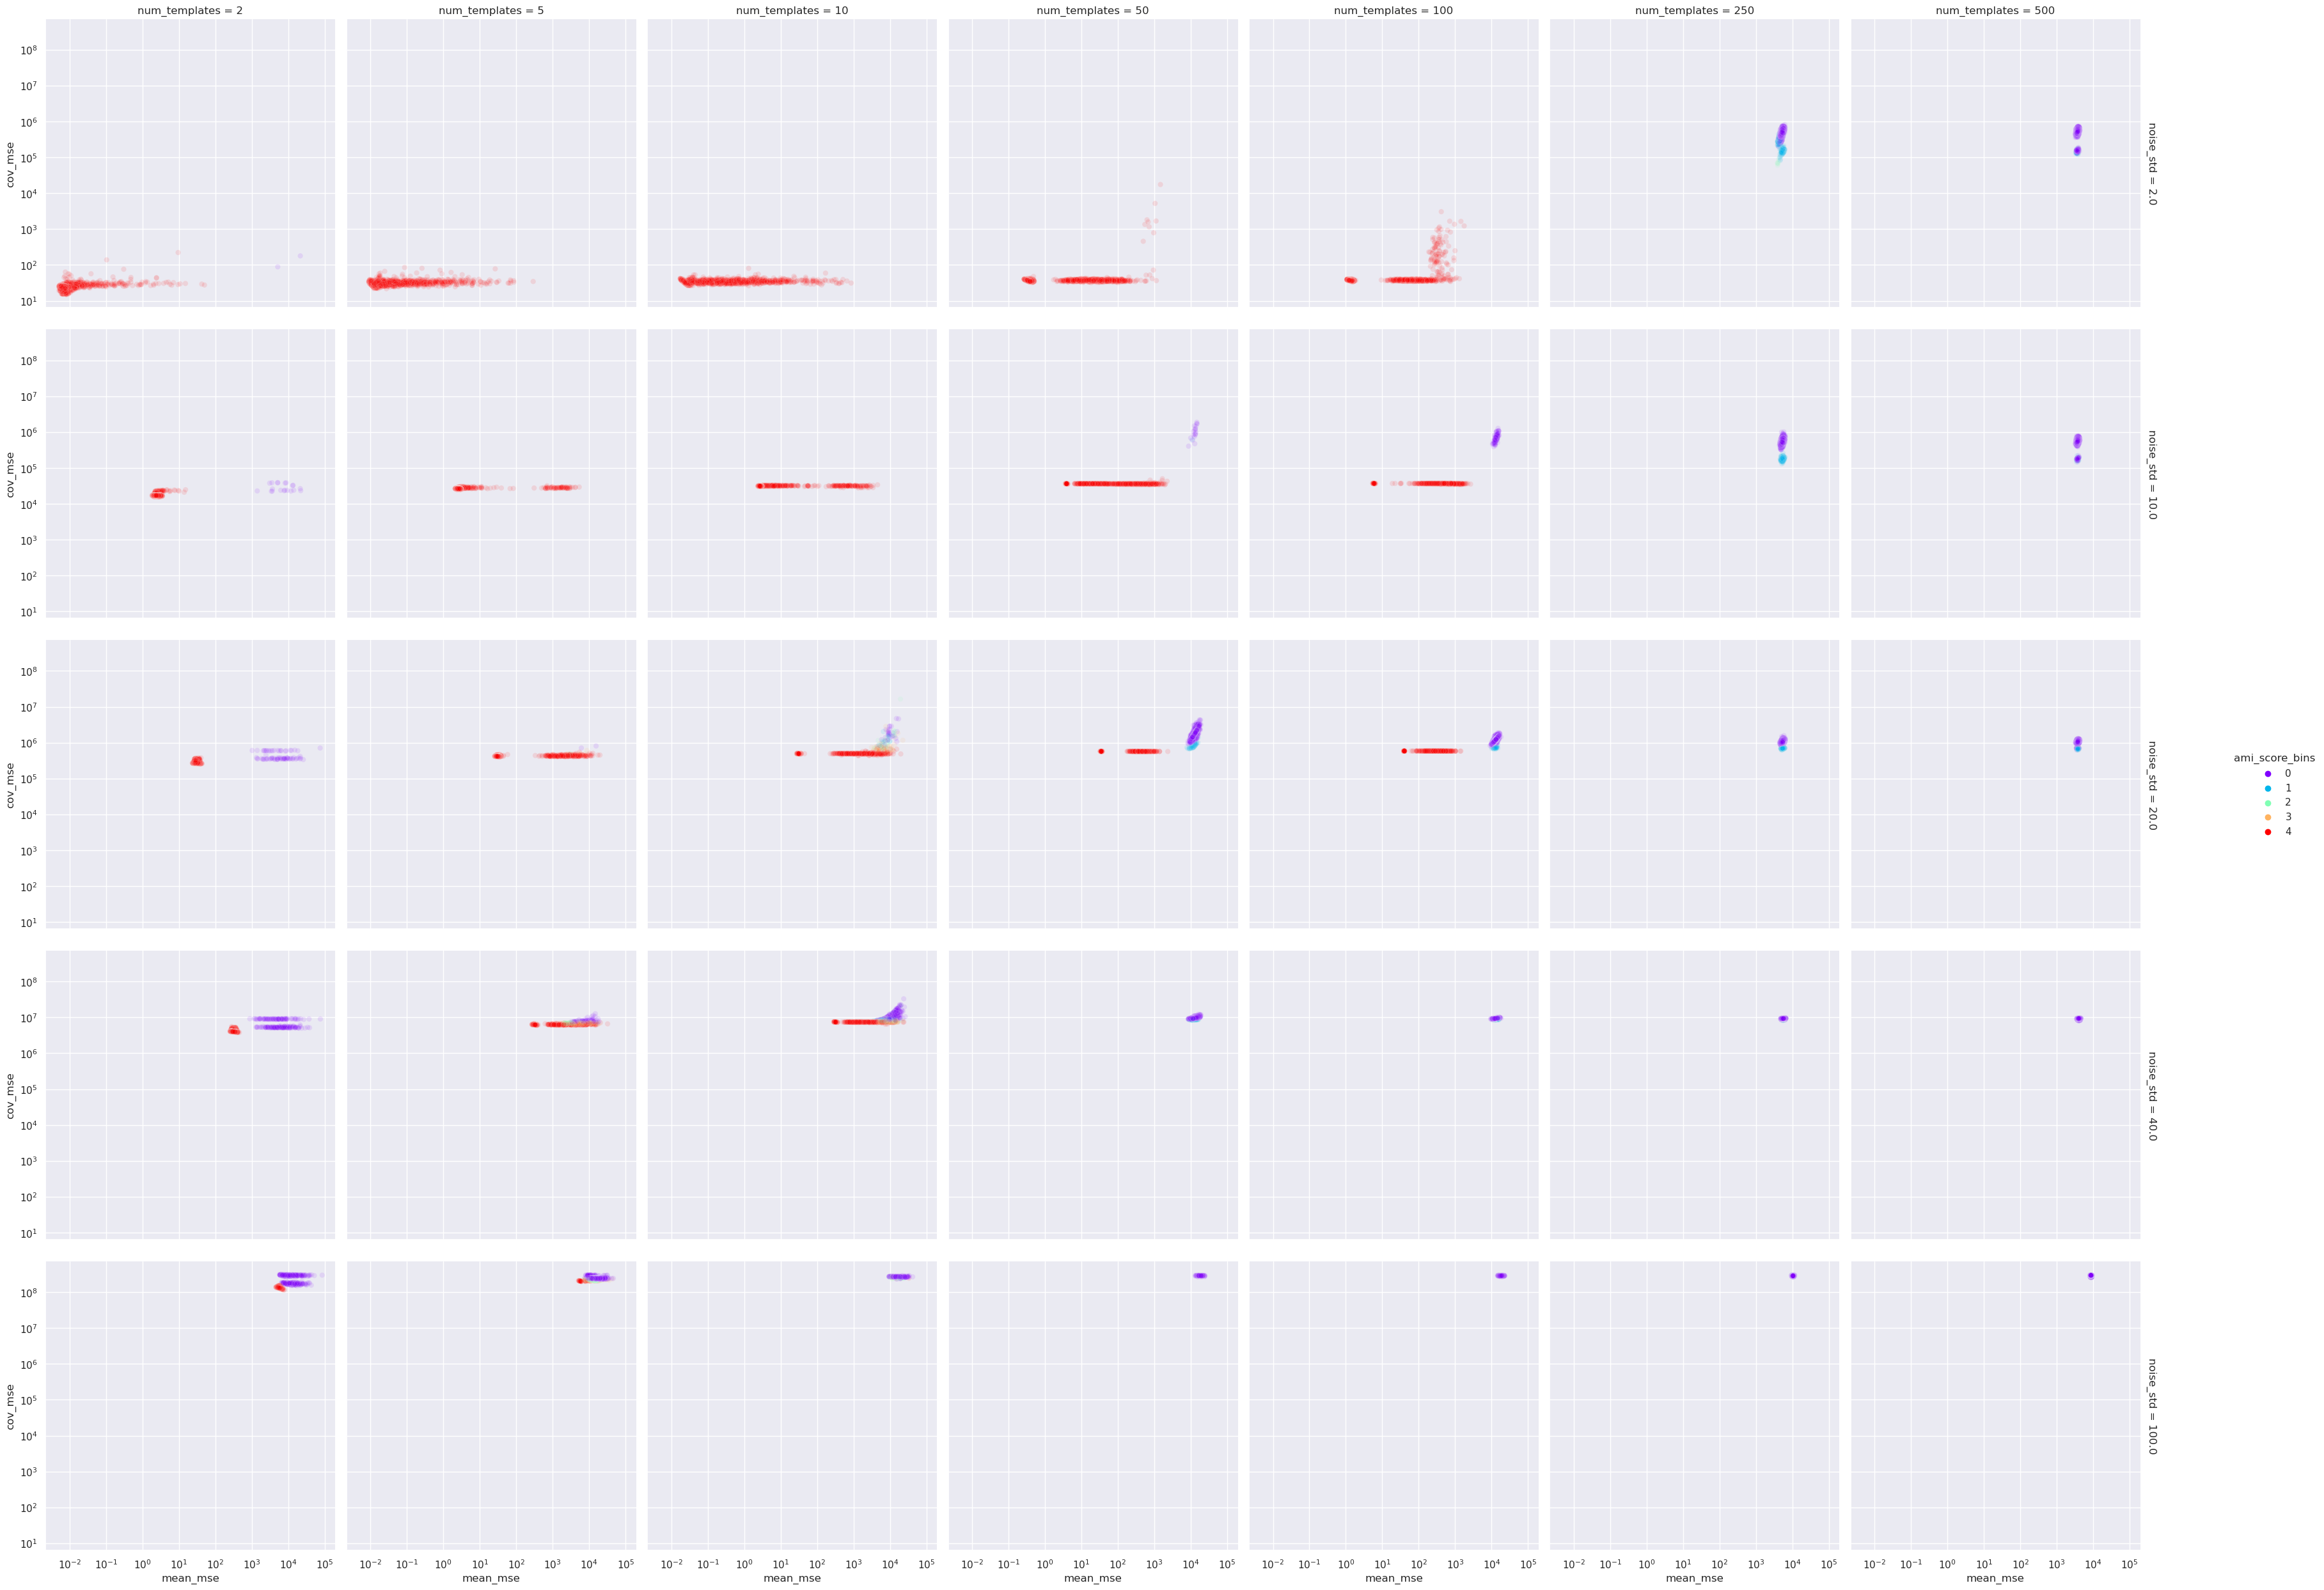

In [47]:
g = sns.relplot(data=combined_df, 
                x="mean_mse", y='cov_mse', col="num_templates", row="noise_std",    
                facet_kws=dict(margin_titles=True), hue='ami_score_bins', alpha=0.1, palette='rainbow')


# Set log scale for x-axis and/or y-axis
g.set(xscale="log", yscale="log")

In [39]:
g = sns.relplot(data=combined_df, 
                x="mean_mse", y='cov_corr',
                hue="ami_score", alpha=0.1, palette='bright')

ValueError: Image size of 685x225146 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 725.625x500 with 1 Axes>